In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "cs231n-briancy02/assignments/assignment2/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n-briancy02/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n-briancy02/assignments/assignment2


# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise, you will implement a dropout layer and modify your fully connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [3]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.


In [4]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Dropout: Forward Pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [5]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout: Backward Pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less.
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
[FILL THIS IN]


# Fully Connected Networks with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout_keep_ratio` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [7]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout_keep_ratio)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        weight_scale=5e-2,
        dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Relative errors should be around e-6 or less.
    # Note that it's fine if for dropout_keep_ratio=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W0 relative error: 7.70e-08
W1 relative error: 2.06e-04
W2 relative error: 4.48e-07
b0 relative error: 4.66e-09
b1 relative error: 1.26e-09
b2 relative error: 6.11e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704413
W0 relative error: 5.61e-07
W1 relative error: 2.15e-06
W2 relative error: 2.60e-08
b0 relative error: 1.16e-08
b1 relative error: 1.57e-09
b2 relative error: 1.09e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W0 relative error: 3.11e-07
W1 relative error: 5.55e-08
W2 relative error: 6.47e-08
b0 relative error: 2.58e-08
b1 relative error: 1.91e-09
b2 relative error: 9.54e-11



# Regularization Experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [8]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule='adam',
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

Streaming output truncated to the last 5000 lines.
   1.78412390e+00 -2.49276614e+00]
 [ 3.65810432e+01  3.19055229e-01 -1.29391317e+01  1.00609455e+01
  -3.33637047e+01 -1.41644640e+01 -1.93275108e+01 -1.97828746e+00
   1.86730492e+00  1.22884569e+01]
 [-2.08736038e+01  6.38508558e+00 -5.22604084e+00  1.63958530e+01
   2.01146431e+01  1.89002190e+01  1.64046154e+01  5.42971277e+00
  -2.10194016e+01 -1.53825760e+01]
 [ 2.77157879e+01 -1.26185722e+01 -9.56209087e+00  1.82825737e+01
  -3.29747009e+01 -1.42794418e+01 -1.20003157e+01 -7.90539443e-01
   5.11992264e+00  7.43631554e+00]
 [ 1.68250961e+01  2.15019760e+01 -9.71385574e+00  8.38152790e+00
  -3.11779767e-01  4.28623104e+00  6.03470182e+00 -3.51301312e+00
  -5.45768356e+00 -5.53639698e+00]
 [ 5.79487076e+01  7.85430956e+00 -1.64614182e+01  2.12822418e+01
  -4.30226402e+01 -2.97997684e+01 -2.12771721e+01 -3.92735195e+00
   1.17239380e+01  7.40584803e+00]
 [-1.21938252e+00 -4.79041719e+00 -8.34182799e-01 -6.72225666e+00
   1.24909496

/content/drive/My Drive/cs231n-briancy02/assignments/assignment2/cs231n/layers.py:199: RuntimeWarning: overflow encountered in exp
  loss = -1 * correct_scores + np.log(np.exp(x).sum(axis=1))


Streaming output truncated to the last 5000 lines.
 [2.39934692e-21 4.60455614e-79 5.17167350e-48 1.00000000e+00
  8.24663909e-61 1.45929448e-59 2.34374543e-62 1.46687967e-57
  1.30403769e-75 1.68153419e-63]
 [1.84227254e-11 1.07951140e-09 3.68686016e-13 2.23687792e-07
  2.80402109e-05 1.00000000e+00 5.04019879e-03 8.12749375e-14
  2.47423771e-17 1.17147495e-11]
 [3.96163348e-36 3.02585590e-16 1.00000000e+00 1.44531189e-29
  2.57896531e-34 6.80022761e-18 3.83373895e-22 6.81522144e-19
  2.89484708e-28 4.87018852e-26]
 [1.21398802e-11 5.28238866e-22 4.16591467e-11 1.09881739e-22
  1.00000000e+00 7.14687316e-23 1.37436538e-42 1.36075256e-12
  2.01940552e-11 2.12801562e-23]
 [1.27462129e-10 1.78759096e-13 2.25998025e-06 1.00000000e+00
  5.39944521e-08 3.17506501e-09 1.27796467e-07 2.73771354e-16
  8.38945813e-14 1.73510270e-23]
 [1.44047948e-13 1.73894550e-11 1.21371191e-05 1.48922661e-07
  6.14464041e-06 5.75735463e-01 5.63652155e-04 1.00000000e+00
  1.51394495e-19 6.92766963e-14]
 [9.811

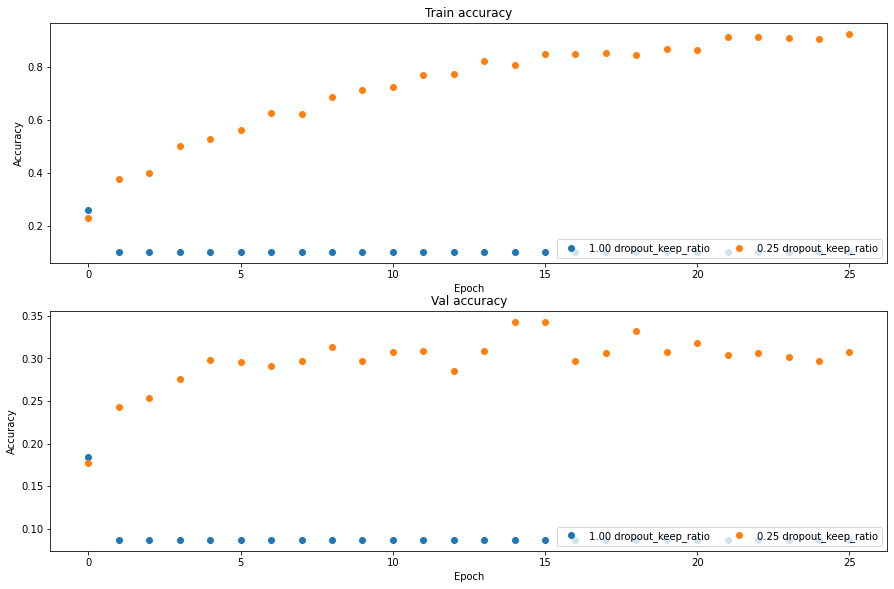

In [ ]:
# Plot train and validation accuracies of the two models.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
[FILL THIS IN]


## Inline Question 3:
Suppose we are training a deep fully connected network for image classification, with dropout after hidden layers (parameterized by keep probability `p`). If we are concerned about overfitting, how should we modify `p` (if at all) when we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:
[FILL THIS IN]
